This notebook reproduces the figures for “Bayesian PSD Estimation for LISA Noise Based on P-Splines with a Parametric Boost” using data from the [npc zenodo rep.](https://doi.org/10.5281/zenodo.17121928)

In [51]:
import h5py
from matplotlib.ticker import NullLocator,  AutoMinorLocator,  FixedLocator, FuncFormatter
from types import SimpleNamespace
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import requests
import os
from urllib.parse import urlparse


In [52]:
np.random.seed(498)
BASE = 10
mpl.rcParams.update({
    "font.size": BASE,
    "axes.labelsize": BASE,
    "xtick.labelsize": BASE,
    "ytick.labelsize": BASE,
    "legend.fontsize": BASE,
})
dpi=300


In [53]:
#downloading the data from Zenodo:
np.random.seed(498)

def download(url: str, dest_folder: str):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    filename = os.path.basename(urlparse(url).path)  # -> "tdi_1y.h5"
    file_path = os.path.join(dest_folder, filename)
    r = requests.get(url, stream=True)
    if r.ok:
        print("saving to", file_path)
        with open(file_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024*8):
                if chunk:
                    f.write(chunk); f.flush(); os.fsync(f.fileno())
    else:
        print(f"Download failed: status code {r.status_code}\n{r.text}")

def tdi_transfer_functions(freq, armlength=2.5e9):
    """
    TDI transfer functions for test mass and OMS noise.

    Args:
        freq (array): frequencies [Hz]
        armlength (float): LISA arm length [m]

    Returns:
        tuple: (tf_testmass, tf_oms) - transfer function amplitudes
    """
    c = 299792458  # speed of light [m/s]
    L = armlength / c  # arm length in seconds

    # Common TDI factor
    common = (
        16
        * np.sin(2 * np.pi * freq * L) ** 2
        * np.sin(4 * np.pi * freq * L) ** 2
    )

    # Test mass transfer function
    tf_testmass = np.sqrt(common * (3 + np.cos(4 * np.pi * freq * L)))

    # OMS transfer function
    tf_oms = np.sqrt(4 * common)

    return tf_testmass, tf_oms

def oms_noise_asd(
    freq,
    a_OMS=7.9e-12,
    fknee=2e-3,
    central_freq=2.81e14,):
    """
    OMS noise ASD in ISI carrier beatnote fluctuations without filter approximations.

    Args:
        freq (array): frequencies [Hz]
        asd (float): OMS displacement noise parameter[m/s^2]
        fknee (float): knee frequency [Hz]
        central_freq (float): laser central frequency [Hz]
    Returns:
        array: noise PSD [1/Hz]
    """
    c = 299792458
    armlength=2.5e9
    psd_meters = a_OMS**2 * (1 + (fknee / freq) ** 4)
    _, tf_oms = tdi_transfer_functions(freq, armlength)
    asd_hertz = np.sqrt((2 * np.pi * freq * central_freq / c) ** 2 * psd_meters)*tf_oms
    return asd_hertz

def testmass_noise_asd(
    freq,
    a_TM=2.4e-15,
    fknee=4e-4,
    central_freq=2.81e14,
    armlength=2.5e9,
):
    """
    Test mass noise PSD in TMI carrier beatnote fluctuations without filter approximations.

    Args:
        freq (array): frequencies [Hz]
        asd (float): test mass acceleration noise parameter [m/s^2]
        fknee (float): knee frequency [Hz]
        central_freq (float): laser central frequency [Hz]
    Returns:
        array: noise PSD [1/Hz]
    """
    c = 299792458  # speed of light [m/s]
    psd_acc = a_TM**2 * (1 + (fknee / freq) ** 2)
    tf_tm, _ = tdi_transfer_functions(freq, armlength)

    asd_hertz = np.sqrt((2 * central_freq / (2 * np.pi * c * freq)) ** 2 * psd_acc)*tf_tm
    return asd_hertz



def darken(color, amount=0.55):
    r, g, b = mcolors.to_rgb(color)
    return (r*amount, g*amount, b*amount)

def box(model1_file,model2_file,n_values, init_values=None, xlab="Time series length"):

    txt_files = {
    "Model 1": model1_file,
    "Model 2": model2_file,
    }
    initial_values = {
    "Model 1": {n_values[0]: None, n_values[1]: None, n_values[2]: None},
    "Model 2": {n_values[0]: None, n_values[1]: None, n_values[2]: None},
    }
    color_map = {"Model 1": "tab:green", "Model 2": "tab:orange"}
    dfs = []
    for model, path in txt_files.items():
        arr = np.loadtxt(path, skiprows=1)
        df  = pd.DataFrame(arr, columns=n_values).melt(var_name="n", value_name="iae")
        df["model"] = model
        dfs.append(df)
    data = pd.concat(dfs, ignore_index=True)
    data["n"] = pd.Categorical(data["n"], categories=n_values, ordered=True)
    by_model_n = {}
    for model in txt_files.keys():
     sub = data[data["model"] == model]
     by_model_n[model] = {int(n): sub[sub["n"] == n]["iae"].to_numpy() for n in n_values}
    fig, ax = plt.subplots(figsize=(6, 4))
    offset    = 0.20
    alpha_box = 0.65
    group_gap = 0.60
    width = 0.30
    x_centers = 1 + np.arange(len(n_values)) * (1.0 + group_gap)
    ax.set_xticks(x_centers)
    ax.set_xticklabels([str(n) for n in n_values])
    positions = {
        "Model 1": x_centers - offset,
        "Model 2": x_centers + offset,
    }
    for model in ["Model 1", "Model 2"]:
        face = color_map[model]
        edge = darken(face, 0.55)
        pos  = positions[model]
        series = [by_model_n[model][n] for n in n_values]

        ax.boxplot(
         series,
         positions=pos,
         widths=width,
         notch=False,
         patch_artist=True,
         showfliers=False,
         boxprops=dict(facecolor=face, edgecolor=edge, linewidth=1.2, alpha=alpha_box),
         whiskerprops=dict(color=edge, linewidth=1.2, alpha=alpha_box),
         capprops=dict(color=edge, linewidth=1.2, alpha=alpha_box),
         medianprops=dict(color=edge, linewidth=1.4, alpha=1.0),
        )
    marker_len = 0.38
    for model in ["Model 1", "Model 2"]:
        col_dark = darken(color_map[model], 0.55)
        for i, n in enumerate(n_values):
            y = initial_values[model].get(n)
            if y is None:
                continue
            x = positions[model][i]
            ax.hlines(y, x - marker_len/2, x + marker_len/2, colors=col_dark, linewidth=1.8, ls="--")
    ax.set_xticks(x_centers)
    ax.set_xticklabels([str(n) for n in n_values])
    ax.set_xlabel(xlab)
    ax.set_ylabel("IAE")
    ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=True)

    # ticks
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis="y", which="major", direction="in", left=True, right=True, length=4, width=0.8)
    ax.tick_params(axis="y", which="minor", direction="in", left=True, right=True, length=2, width=0.6)
    ax.xaxis.set_minor_locator(NullLocator())
    legend_elements = [
    Line2D([0], [0], color=color_map["Model 1"], lw=6, alpha=alpha_box, label="Model 1"),
    Line2D([0], [0], color=color_map["Model 2"], lw=6, alpha=alpha_box, label="Model 2"),
    ]
    if any(v is not None for d in initial_values.values() for v in d.values()):
        legend_elements.append(Line2D([0], [0], color="gray", lw=2, ls="--", label="Initial value"))
    ax.legend(handles=legend_elements, frameon=False)
    ax.grid(False)
    for side in ("top", "right", "left", "bottom"):
        ax.spines[side].set_visible(True)
    plt.show()


saving to data/iae_ar0.txt
saving to data/iae_ar4.txt


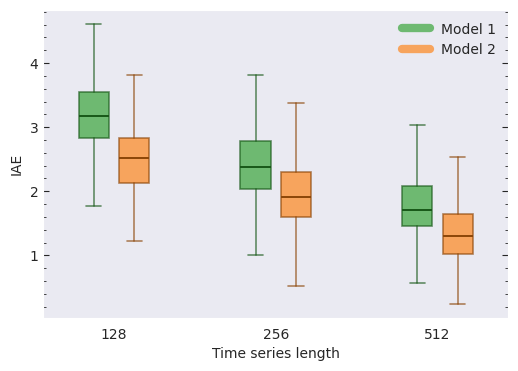

In [54]:
dire = "https://zenodo.org/records/17128712/files"
download(f"{dire}/iae_ar0.txt?download=1", "data")
download(f"{dire}/iae_ar4.txt?download=1", "data")

box("data/iae_ar0.txt","data/iae_ar4.txt",n_values=[128,256,512])

saving to data/iae_ar0_knots.txt
saving to data/iae_ar4_knots.txt


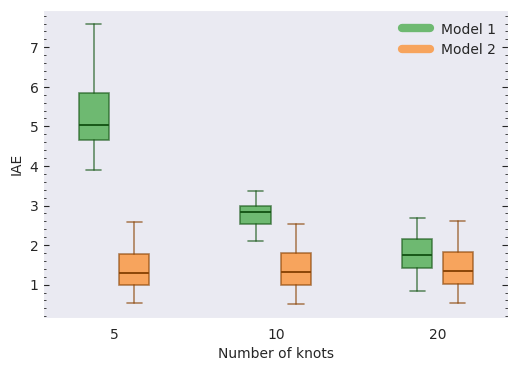

In [55]:
download(f"{dire}/iae_ar0_knots.txt?download=1", "data")
download(f"{dire}/iae_ar4_knots.txt?download=1", "data")

box("data/iae_ar0_knots.txt","data/iae_ar4_knots.txt",n_values=[5,10,20], xlab="Number of knots")


saving to data/mcmc_results_289.h5
saving to data/mcmc_results_498.h5
saving to data/freq.txt
saving to data/ar4spec.txt
mcmc_results_289.h5:  iae = 0.576346
mcmc_results_498.h5:  iae = 0.202162


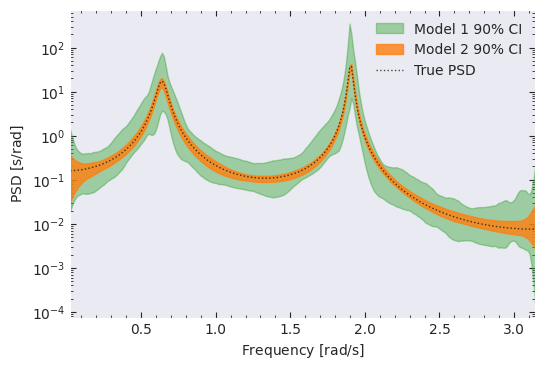

In [56]:
download(f"{dire}/mcmc_results_289.h5?download=1", "data")
download(f"{dire}/mcmc_results_498.h5?download=1", "data")
download(f"{dire}/freq.txt?download=1", "data")
download(f"{dire}/ar4spec.txt?download=1", "data")
base_dir="/home/naim769/PycharmProjects/npc/tests/data"
ci_files = {"Model 1": "mcmc_results_289.h5",
            "Model 2": "mcmc_results_498.h5"}
freq     = np.loadtxt(f"{base_dir}/freq.txt")
true_psd = np.loadtxt(f"{base_dir}/ar4spec.txt")
colors = {"Model 1": "tab:green", "Model 2": "tab:orange"}
alpha  = {"Model 1": 0.40,        "Model 2": 0.8}

fig, ax = plt.subplots(figsize=(6,4))
for model, fname in ci_files.items():
    with h5py.File(f"{base_dir}/{fname}", "r") as h5f:
        g   = h5f["mcmc"] if "mcmc" in h5f else h5f
        lwr = g["npsd_u05"][()]
        upr = g["npsd_u95"][()]
        llike=g["loglikelihood"][()]
        lambda_mat=g["lam_mat"][()]
        iae = h5f["mcmc"].attrs["iae"]
        print(f"{fname:>7}:  iae = {iae:.6g}")
    ax.fill_between(freq, np.exp(lwr), np.exp(upr),
                    color=colors[model], alpha=alpha[model],
                    label=f"{model} 90% CI")

ax.plot(freq, true_psd, color="k", ls=":", lw=1, alpha=0.7, label="True PSD")
ax.set_yscale("log")
ax.set_xlim(freq.min(), freq.max())
ax.set_xlabel("Frequency [$\mathrm{rad/s}$]")
ax.set_ylabel(r"PSD [$\mathrm{s/rad}$]")
ax.grid(False)
ax.legend(loc="upper right", frameon=False)

for a in (ax,):
    a.minorticks_on()
    ax.tick_params(axis="both", which="both",
                   direction="in", top=True, bottom=True, left=True, right=True,
                   length=4, width=0.8)
    a.tick_params(which="minor", length=2, width=0.6)
plt.show()

In [57]:
def load_ci(data_dir: str, tag: str):
    ffile = {"3mon": "ddpc_f_3mon.txt",
             "6mon": "ddpc_f_6mon.txt",
             "1year": "ddpc_f_1year.txt"}[tag]
    h5file = f"mcmc_results_{tag}.h5"

    f = np.loadtxt(os.path.join(data_dir, ffile))
    with h5py.File(os.path.join(data_dir, h5file), "r") as h5f:
        g = h5f["mcmc"]
        ci = SimpleNamespace(
            u05 = g["npsd_u05"][...],
            med = g["npsd_med"][...],
            u95 = g["npsd_u95"][...],
        )
    return f, ci

def load_periodogram_1year(data_dir: str):
    p = np.loadtxt(os.path.join(data_dir, "ddpc_x2_per_1year.txt"))
    if p.ndim > 1:
        p = p[0]
    return p

def model_psd(f):
    return (oms_noise_asd(f)**2 + testmass_noise_asd(f)**2)

def ticks_all(ax, xmin, xmax):
    ax.set_xscale("log")
    ax.set_xlim(xmin, xmax)
    ticks = np.array([1.03e-4, 1e-3, 9.99e-3])
    ax.xaxis.set_major_locator(FixedLocator(ticks))
    def fmt(v, pos):
        if np.isclose(v, 1.03e-4): return r"$10^{-4}$"
        if np.isclose(v, 1e-3):    return r"$10^{-3}$"
        if np.isclose(v, 9.99e-3): return r"$10^{-2}$"
        return ""
    ax.xaxis.set_major_formatter(FuncFormatter(fmt))
    ax.xaxis.set_minor_locator(FixedLocator(ticks))
    ax.minorticks_on()
    ax.tick_params(axis="both", which="both",
                       direction="in", top=True, bottom=True, left=True, right=True,
                       length=4, width=0.8)
    ax.tick_params(which="minor", length=2, width=0.6)

def three_oranges():
    cmap = plt.get_cmap("Oranges")
    return [cmap(0.4), cmap(0.6), cmap(0.8)]

def plot_overlaid_t_psd(ax, data_dir="data", tags=("3mon", "6mon", "1year")):
    reds = three_oranges()
    shade     = dict(zip(tags, reds))
    alpha_map = {"3mon": 0.35, "6mon": 0.45, "1year": 0.55}

    for tag in tags:
        f, ci = load_ci(data_dir, tag)
        col = shade[tag]
        lbl = {"3mon": "3-months", "6mon": "6-months", "1year": "1-year"}[tag]
        ax.fill_between(f, np.exp(ci.u05), np.exp(ci.u95),
                        color=col, alpha=alpha_map[tag], label=lbl)

        if tag == "1year":
            x2per = load_periodogram_1year(data_dir)
            true_psd = model_psd(f)

    ax.plot(f, x2per, color="black", alpha=0.10, label="X-channel periodogram")
    ax.plot(f, true_psd, color="black", ls=":", label="Theoretical PSD" )
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylabel(r"PSD [$\mathrm{Hz}^{-1}$]")
    ax.legend(frameon=False, ncol=2, handlelength=1.2, columnspacing=0.8)
    ax.grid(False)

def plot_error_subplot(ax, data_dir="data", tags=("3mon", "6mon", "1year")):
    reds = three_oranges()
    shade = dict(zip(tags, reds))

    for tag in tags:
        f, ci = load_ci(data_dir, tag)
        true_psd = model_psd(f)
        col = shade[tag]

        err_low  = (ci.u05 - np.log(true_psd))  / abs(np.log(true_psd))
        err_high  = (ci.u95 - np.log(true_psd)) / abs(np.log(true_psd))
        print(f"{tag:>6}: median rel. error = "
              f"{np.median(np.abs((ci.med - np.log(true_psd)) / np.log(true_psd))):.6g}")

        ax.fill_between(f, err_low, err_high,
                        color=col, alpha=0.35,
                        label={"3mon":"3-months","6mon":"6-months","1year":"1-year"}[tag])

    ax.axhline(0, color="black", lw=1, ls=":")
    ax.set_xscale("log")
    ax.set_ylim(-0.03, 0.03)
    ax.set_xlabel("Frequency [$\mathrm{Hz}$]")
    ax.set_ylabel("Relative error")
    ax.grid(False)

def plot_comparison_panel(data_dir="data", tags=("3mon", "6mon", "1year")):
    WIDE = 7.0
    fig, (ax_top, ax_bot) = plt.subplots(
        2, 1, figsize=(WIDE, 3.8), sharex=True,
        gridspec_kw={"height_ratios": [2, 1], "hspace": 0}
    )

    plot_overlaid_t_psd(ax_top, data_dir, tags)
    plot_error_subplot( ax_bot, data_dir, tags)
    for ax in (ax_top, ax_bot):
        ax.minorticks_on()
        ax.tick_params(axis="both", which="both",
                       direction="in", top=True, bottom=True, left=True, right=True,
                       length=4, width=0.8)
        ax.tick_params(which="minor", length=2, width=0.6)

    f1 = np.loadtxt(os.path.join(data_dir, "ddpc_f_1year.txt"))
    ticks_all(ax_top, f1.min(), f1.max())
    ticks_all(ax_bot, f1.min(), f1.max())
    fig.subplots_adjust(left=0.12, right=0.98, top=0.98, bottom=0.10)
    plt.show()

In [8]:
# datasets: Takes approx 38 mins
download(f"{dire}/ddpc_x2_per_1year.txt?download=1", "data")
download(f"{dire}/ddpc_f_1year.txt?download=1", "data")
download(f"{dire}/ddpc_f_6mon.txt?download=1", "data")
download(f"{dire}/ddpc_f_3mon.txt?download=1", "data")
download(f"{dire}/mcmc_results_1year.h5?download=1", "data")
download(f"{dire}/mcmc_results_6mon.h5?download=1", "data")
download(f"{dire}/mcmc_results_3mon.h5?download=1", "data")

saving to data/ddpc_x2_per_1year.txt
saving to data/ddpc_f_1year.txt
saving to data/ddpc_f_6mon.txt
saving to data/ddpc_f_3mon.txt
saving to data/mcmc_results_1year.h5
saving to data/mcmc_results_6mon.h5
saving to data/mcmc_results_3mon.h5


  3mon: median rel. error = 0.000436163
  6mon: median rel. error = 0.000216256
 1year: median rel. error = 0.000146841


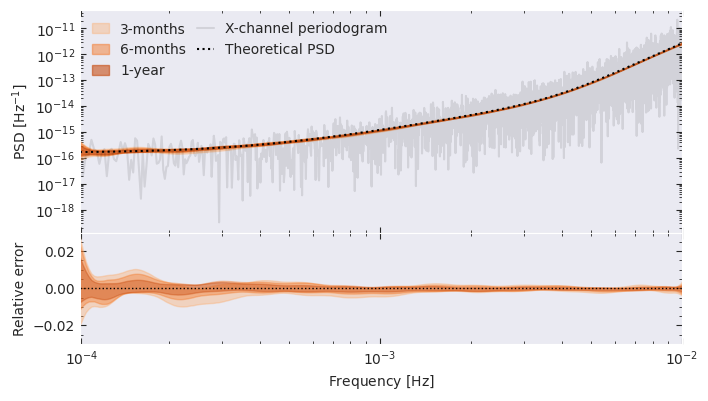

In [58]:
plot_comparison_panel(data_dir="data", tags=("3mon","6mon","1year"))